In [1]:
import numpy as np
import qiskit.pulse as pulse
from qiskit_ibm_provider import IBMProvider

from casq.gates import GaussianPulseGate
from casq.common import plot, plot_bloch, plot_signal, LineStyle, LineType, LineConfig, LegendStyle
from casq.helpers import solver_from_backend
from casq import PulseSolver

%matplotlib inline


In [2]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
from qiskit_dynamics.array import Array
Array.set_default_backend("jax")


In [3]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_manila")
config = backend.configuration()
properties = backend.properties()
solver = PulseSolver.from_backend("ibmq_manila", qubits=[0])


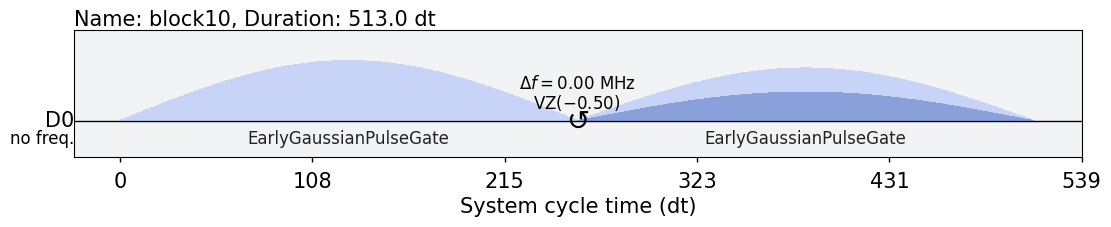

In [4]:
dt = config.dt
qubit = 0
qubit_frequency = properties.frequency(qubit)
duration = 256
sigma = 128

schedules = []

for amplitude in np.linspace(0., 1., 10):
    gpg = GaussianPulseGate(duration, amplitude, sigma)
    with pulse.build() as schedule:
        with pulse.align_sequential():
            gpg.instruction(qubit)
            pulse.shift_phase(0.5, pulse.DriveChannel(qubit))
            pulse.shift_frequency(0.1, pulse.DriveChannel(qubit))
            gpg.instruction(qubit)
            pulse.acquire(duration=1, qubit_or_channel=qubit, register=pulse.MemorySlot(qubit))

    schedules.append(schedule)

schedules[5].draw()


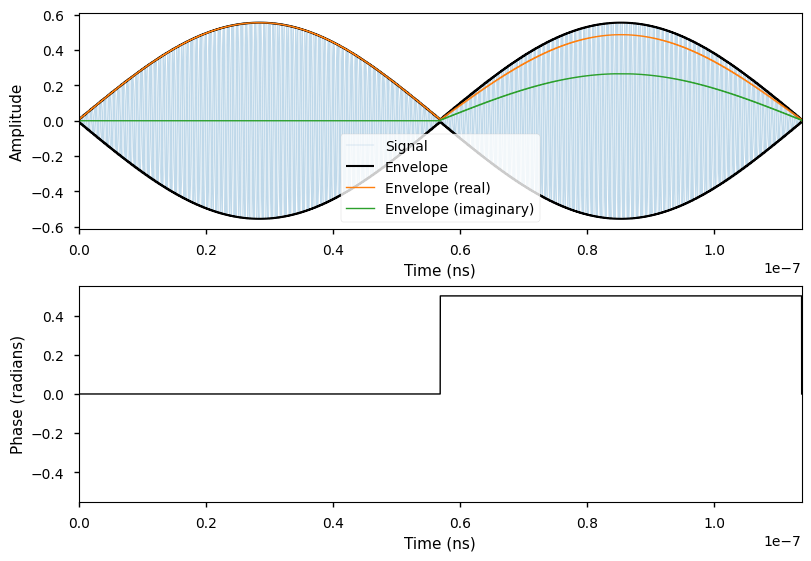

In [5]:
fig = plot_signal(schedules[5], dt, "d0", qubit_frequency, 2*duration*dt)


In [6]:
solutions = {}
for schedule in schedules:
    solution = solver.solve(
        run_input=schedule, steps=100,
        method="jax_odeint", atol=1e-6, rtol=1e-8, hmax=dt
    )
    solutions[schedule.name] = solution


In [7]:
solution0 = solutions[schedules[2].name][0]
print(solution0)


 t: Array([0.00000000e+00, 1.14927048e-09, 2.29854097e-09, 3.44781145e-09,
       4.59708193e-09, 5.74635241e-09, 6.89562290e-09, 8.04489338e-09,
       9.19416386e-09, 1.03434343e-08, 1.14927048e-08, 1.26419753e-08,
       1.37912458e-08, 1.49405163e-08, 1.60897868e-08, 1.72390572e-08,
       1.83883277e-08, 1.95375982e-08, 2.06868687e-08, 2.18361392e-08,
       2.29854097e-08, 2.41346801e-08, 2.52839506e-08, 2.64332211e-08,
       2.75824916e-08, 2.87317621e-08, 2.98810325e-08, 3.10303030e-08,
       3.21795735e-08, 3.33288440e-08, 3.44781145e-08, 3.56273850e-08,
       3.67766554e-08, 3.79259259e-08, 3.90751964e-08, 4.02244669e-08,
       4.13737374e-08, 4.25230079e-08, 4.36722783e-08, 4.48215488e-08,
       4.59708193e-08, 4.71200898e-08, 4.82693603e-08, 4.94186308e-08,
       5.05679012e-08, 5.17171717e-08, 5.28664422e-08, 5.40157127e-08,
       5.51649832e-08, 5.63142536e-08, 5.74635241e-08, 5.86127946e-08,
       5.97620651e-08, 6.09113356e-08, 6.20606061e-08, 6.32098765e-08,
  

In [8]:
x = []
y = []
z = []
for sv in solution0.y:
    xp, yp, zp = sv.data.real
    x.append(xp)
    y.append(yp)
    z.append(zp)
p0 = [sv.probabilities()[0] for sv in solution0.y]
p1 = [sv.probabilities()[1] for sv in solution0.y]


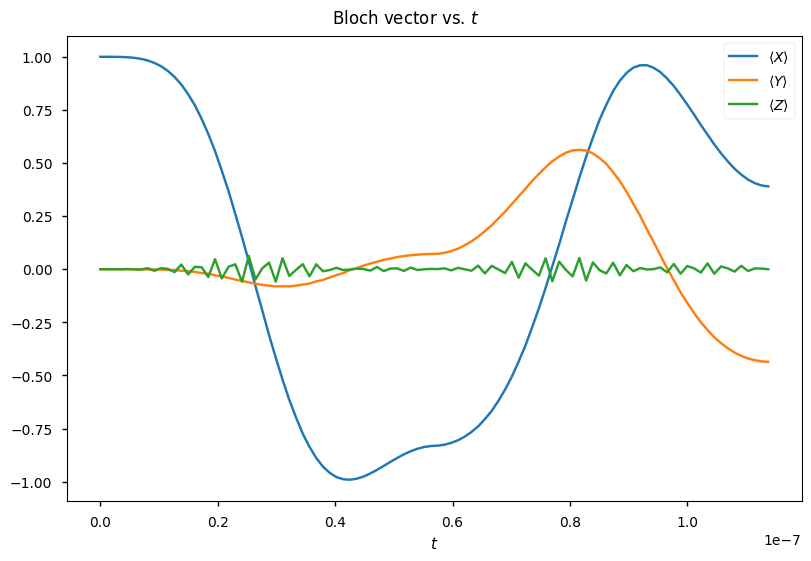

In [9]:
x_config = LineConfig(x=solution0.t, y=x, label="$\\langle X \\rangle$", xtitle="$t$")
y_config = LineConfig(x=solution0.t, y=y, label="$\\langle Y \\rangle$", xtitle="$t$")
z_config = LineConfig(x=solution0.t, y=z, label="$\\langle Z \\rangle$", xtitle="$t$")
fig = plot(
    data=[x_config, y_config, z_config],
    title="Bloch vector vs. $t$", legend_style=LegendStyle()
)


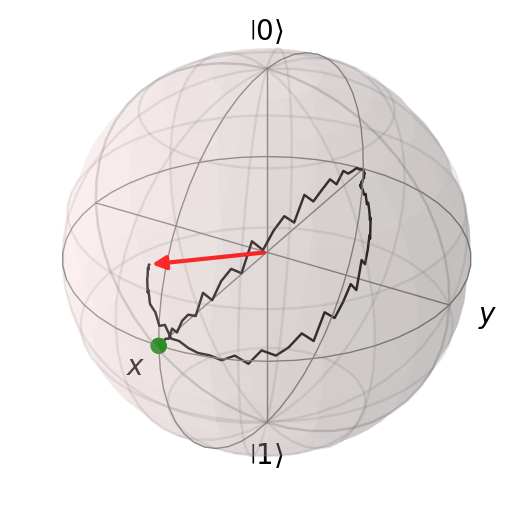

In [10]:
fig = plot_bloch(x, y, z)


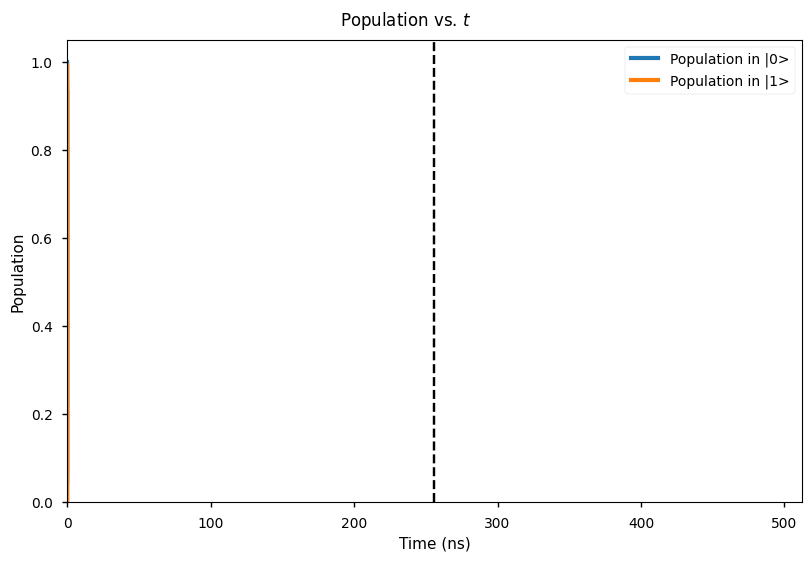

In [11]:
p0_config = LineConfig(
    x=solution0.t, y=p0, label="Population in |0>",
    xlim=(0, 2*duration), ylim=(0, 1.05),
    line_style=LineStyle(size=3), xtitle="Time (ns)", ytitle="Population"
)
p1_config = LineConfig(
    x=solution0.t, y=p1, label="Population in |1>",
    xlim=(0, 2*duration), ylim=(0, 1.05),
    line_style=LineStyle(size=3), xtitle="Time (ns)", ytitle="Population"
)
vline = (duration, None, LineStyle(type=LineType.DASHED, color="black"), None)
fig = plot(
    data=[p0_config, p1_config],
    vlines=[vline],
    title="Population vs. $t$", legend_style=LegendStyle()
)
